# 原始 SHINE 模型

In [1]:
from tensorflow.keras.layers import Input, Dense, Dot, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as bk
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from prepare_data import Data
import os
import numpy as np
import timeit
import matplotlib.pyplot as plt

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ["path"] += os.pathsep + 'c:/program files (x86)/graphviz2.38/bin'
# saveDir = "C:/Users/user/Google 雲端硬碟/NCKU_NETAI/SHINE/DGE/model"

# 一、讀取資料，包含:
1. Sentiment Graph
2. Social Relation Graph
3. Profile Bipartite Graph

In [3]:
train_ratio = 1
data = Data('data/sentiment.csv',
            'data/social_relation.csv',
            'data/celebrity_profile.csv',
            'data/ordinary_user_profile.csv',
            train_ratio,
           random_state=0) # random_state 設0為SHINE原始碼所用之切割，效果會最好，acc約有 80% 左右。

X1_s_train, X2_s_train, y_train, X1_s_test, X2_s_test, y_test, _ = data.get_sentiment_data()
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

X1_r_train, X2_r_train, X1_r_test, X2_r_test, adj_matrix_r = data.get_relation_data()
X1_p_train, X2_p_train, X1_p_test, X2_p_test, o_profile_one_hot, c_profile_one_hot = data.get_profile_data()

input_dim_all_user = X1_s_train.shape[1]
input_dim_op = X1_p_train.shape[1]
input_dim_cp = X2_p_train.shape[1]

---


# 二、建構模型

### 定義幾個 Loss function

In [4]:
# put more weight on non-zero terms
alpha = 10
def reconstruction_loss(y_true, y_pred):
    sqr = bk.square(y_pred - y_true)
    weight = bk.abs(y_true) * (alpha - 1) + 1
    return bk.sum(sqr * weight, axis=-1)

def proximity_loss(y_true, y_pred):
    return bk.sum(-y_pred * y_true, axis=-1)

def proximity_loss_paper(y_true, y_pred):
      return  bk.sum(bk.square(y_true - y_pred))

### 定義超參數

In [5]:
epoch_size = 5
batch_size = 512
EMBEDDING_DIM = 64
l2_weight = 0.01
lambda_sen = 1
lambda_soc = 1
lambda_pro = 1
lambda_output = 30
sen_act = 'tanh'
soc_act = 'sigmoid'
pro_act = 'sigmoid'
optimizer = 'adam'
recon_loss = reconstruction_loss
proxi_loss = proximity_loss

### 定義模型結構

In [6]:
input_dim_all_user = X1_s_train.shape[1]
input_dim_op = X1_p_train.shape[1]
input_dim_cp = X2_p_train.shape[1]

########## Sentiment graph autoencoder ##########
# Input layer
sen_holder_input = Input(shape=(input_dim_all_user,))
sen_target_input = Input(shape=(input_dim_all_user,))

# encoder
sen_encoder = Dense(EMBEDDING_DIM, activation=sen_act, kernel_regularizer=l2(l2_weight))
sen_holder_emb = sen_encoder(sen_holder_input)
sen_target_emb = sen_encoder(sen_target_input)

# decoder
sen_decoder = Dense(input_dim_all_user, activation=sen_act, kernel_regularizer=l2(l2_weight))
sen_recon_holder = sen_decoder(sen_holder_emb)
sen_recon_target = sen_decoder(sen_target_emb)

# dot product of two users
sen_proximity = Dot(axes=-1, normalize=True)([sen_holder_emb, sen_target_emb])


########## Social relation graph autoencoder ##########
# Input layer
soc_holder_input = Input(shape=(input_dim_all_user,))
soc_target_input = Input(shape=(input_dim_all_user,))

# encoder
soc_encoder = Dense(EMBEDDING_DIM, activation=soc_act, kernel_regularizer=l2(l2_weight))
soc_holder_emb = soc_encoder(soc_holder_input)
soc_target_emb = soc_encoder(soc_target_input)

# decoder
soc_decoder = Dense(input_dim_all_user, activation=soc_act, kernel_regularizer=l2(l2_weight))
soc_recon_holder = soc_decoder(soc_holder_emb)
soc_recon_target = soc_decoder(soc_target_emb)

# dot product of two users
soc_proximity = Dot(axes=-1, normalize=True)([soc_holder_emb, soc_target_emb])


########## Profile graph autoencoder ##########
# o: ordinary people, c: celebrity
# Input layer
pro_o_input = Input(shape=(input_dim_op,))
pro_c_input = Input(shape=(input_dim_cp,))

# encoder
pro_o_encoder = Dense(EMBEDDING_DIM, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_c_encoder = Dense(EMBEDDING_DIM, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_o_emb = pro_o_encoder(pro_o_input)
pro_c_emb = pro_c_encoder(pro_c_input)

# decoder
pro_o_decoder = Dense(input_dim_op, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_c_decoder = Dense(input_dim_cp, activation=pro_act, kernel_regularizer=l2(l2_weight))
pro_recon_o = pro_o_decoder(pro_o_emb)
pro_recon_c = pro_c_decoder(pro_c_emb)

# dot product of two users
pro_proximity = Dot(axes=-1, normalize=True)([pro_o_emb, pro_c_emb])


########## Aggregation layer ##########
# 最終預測情感值
proximity = Add()([sen_proximity, soc_proximity, pro_proximity])

# 訓練用模型
model = Model(inputs=[sen_holder_input, sen_target_input, soc_holder_input, soc_target_input, pro_o_input, pro_c_input],
              outputs=[sen_recon_holder, sen_recon_target, soc_recon_holder, soc_recon_target, pro_recon_o, pro_recon_c, proximity])
model.compile(optimizer=optimizer,
              loss=[recon_loss, recon_loss, recon_loss,
                    recon_loss, recon_loss, recon_loss, proxi_loss],
              loss_weights=[lambda_sen, lambda_sen, lambda_soc, lambda_soc, lambda_pro, lambda_pro, lambda_output])

# 預測用模型
predict_model = Model(inputs=[sen_holder_input, sen_target_input, soc_holder_input, soc_target_input, pro_o_input, pro_c_input],
                      outputs=proximity)

### 訓練模型

In [7]:
start = timeit.default_timer()
h = model.fit(x=[X1_s_train, X2_s_train, X1_r_train, X2_r_train, X1_p_train, X2_p_train],
              y=[X1_s_train, X2_s_train, X1_r_train, X2_r_train, X1_p_train, X2_p_train, y_train],
              epochs=epoch_size,
              batch_size=batch_size,
              validation_data=([X1_s_test, X2_s_test, X1_r_test, X2_r_test, X1_p_test, X2_p_test],
                               [X1_s_test, X2_s_test, X1_r_test, X2_r_test, X1_p_test, X2_p_test, y_test]),
             verbose=1)
stop = timeit.default_timer()
print('Time: ', stop - start) 

Epoch 1/3
103/103 [==============================] - 21s 205ms/step - loss: 3425.7080 - dense_1_loss: 117.4875 - dense_1_1_loss: 423.8878 - dense_3_loss: 1282.7574 - dense_3_1_loss: 1582.3510 - dense_6_loss: 7.2077 - dense_7_loss: 27.6186 - add_loss: -2.0316 - val_loss: 1511.3995 - val_dense_1_loss: 87.2114 - val_dense_1_1_loss: 210.5212 - val_dense_3_loss: 341.6634 - val_dense_3_1_loss: 773.0676 - val_dense_6_loss: 6.1179 - val_dense_7_loss: 22.7360 - val_add_loss: -0.1516
Epoch 2/3
103/103 [==============================] - 24s 234ms/step - loss: 1350.3778 - dense_1_loss: 92.0806 - dense_1_1_loss: 190.1527 - dense_3_loss: 307.3583 - dense_3_1_loss: 708.7907 - dense_6_loss: 5.6958 - dense_7_loss: 21.4318 - add_loss: -2.0482 - val_loss: 1338.9807 - val_dense_1_loss: 79.6310 - val_dense_1_1_loss: 170.6544 - val_dense_3_loss: 269.5916 - val_dense_3_1_loss: 702.1226 - val_dense_6_loss: 5.7065 - val_dense_7_loss: 20.3604 - val_add_loss: -0.1418
Epoch 3/3
103/103 [==========================

### 繪製訓練誤差與驗證誤差圖，此處只看最終預測值的誤差而不看 Reconstruction

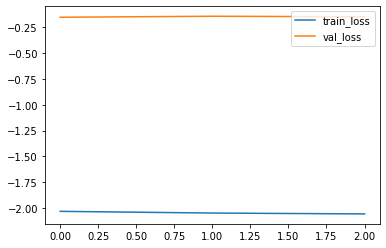

In [8]:
plt.plot(h.history['add_loss'], label='train_loss')
plt.plot(h.history['val_add_loss'], label='val_loss')
plt.legend(loc='upper right')

plt.show()

### 效果評估

In [9]:
def result(X, Y, mode=''):
    # 模型預測值
    y_predict_raw = predict_model.predict(X).flatten()
    y_predict = y_predict_raw.copy()
    
    # 計算中位數當作二分的門檻值
    y_threshold = np.median(y_predict_raw)
    y_predict[y_predict_raw < y_threshold] = -1
    y_predict[y_predict_raw >= y_threshold] = 1
    
    # 用 Ground Truth 計算各種 Metrics
    accuracy = accuracy_score(Y, y_predict)
    f1 = f1_score(Y, y_predict, average='binary')
    AUC = roc_auc_score(Y, y_predict_raw)
    print(mode)
    print(accuracy)
    print(f1)
    print(AUC)
    print()


print("Acc, F1, AUC:")
result(X=[X1_s_train, X2_s_train, X1_r_train, X2_r_train, X1_p_train, X2_p_train], Y=y_train, mode='Train')
result(X=[X1_s_test, X2_s_test, X1_r_test, X2_r_test, X1_p_test, X2_p_test], Y=y_test, mode='Test')

Acc, F1, AUC:
Train
0.6074594925099358
0.7180036237852084
0.9963254738625138

Test
0.8065573770491803
0.8065573770491803
0.8942287019618382

